In [100]:
import warnings
warnings.filterwarnings('ignore')
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from itertools import product
# For seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose, STL
# Import additional functions needed
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA

# to measure model performance
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
# To model with sklearn
from sklearn.linear_model import Lasso, Ridge, LinearRegression, HuberRegressor, ElasticNet

In [94]:
# Some code to help you load the data in the right format
df = pd.read_csv('https://raw.githubusercontent.com/Mcompetitions/M4-methods/refs/heads/master/Dataset/Train/Hourly-train.csv', index_col=0)
df = df.transpose()
index = pd.date_range(start='2024-01-01', periods=len(df), freq='h')
df.set_index(index, inplace=True)
df.head(1)

V1,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,...,H405,H406,H407,H408,H409,H410,H411,H412,H413,H414
2024-01-01,605.0,3124.0,1828.0,6454.0,4263.0,5780.0,52817.0,32479.0,39455.0,513.0,...,68.0,21.0,214.0,19.0,31.0,153.0,24.0,19.0,21.0,15.0


In [95]:
ts = df.iloc[:, -1]
ts

2024-01-01 00:00:00    15.0
2024-01-01 01:00:00    13.0
2024-01-01 02:00:00    13.0
2024-01-01 03:00:00    16.0
2024-01-01 04:00:00    26.0
                       ... 
2024-02-09 19:00:00    48.0
2024-02-09 20:00:00    41.0
2024-02-09 21:00:00    35.0
2024-02-09 22:00:00    26.0
2024-02-09 23:00:00    17.0
Freq: h, Name: H414, Length: 960, dtype: float64

In [96]:
h414 = ts.copy()
h414.head()

2024-01-01 00:00:00    15.0
2024-01-01 01:00:00    13.0
2024-01-01 02:00:00    13.0
2024-01-01 03:00:00    16.0
2024-01-01 04:00:00    26.0
Freq: h, Name: H414, dtype: float64

In [97]:
np.mean(h414.isnull().sum())

np.float64(0.0)

In [98]:
h414.shape

(960,)

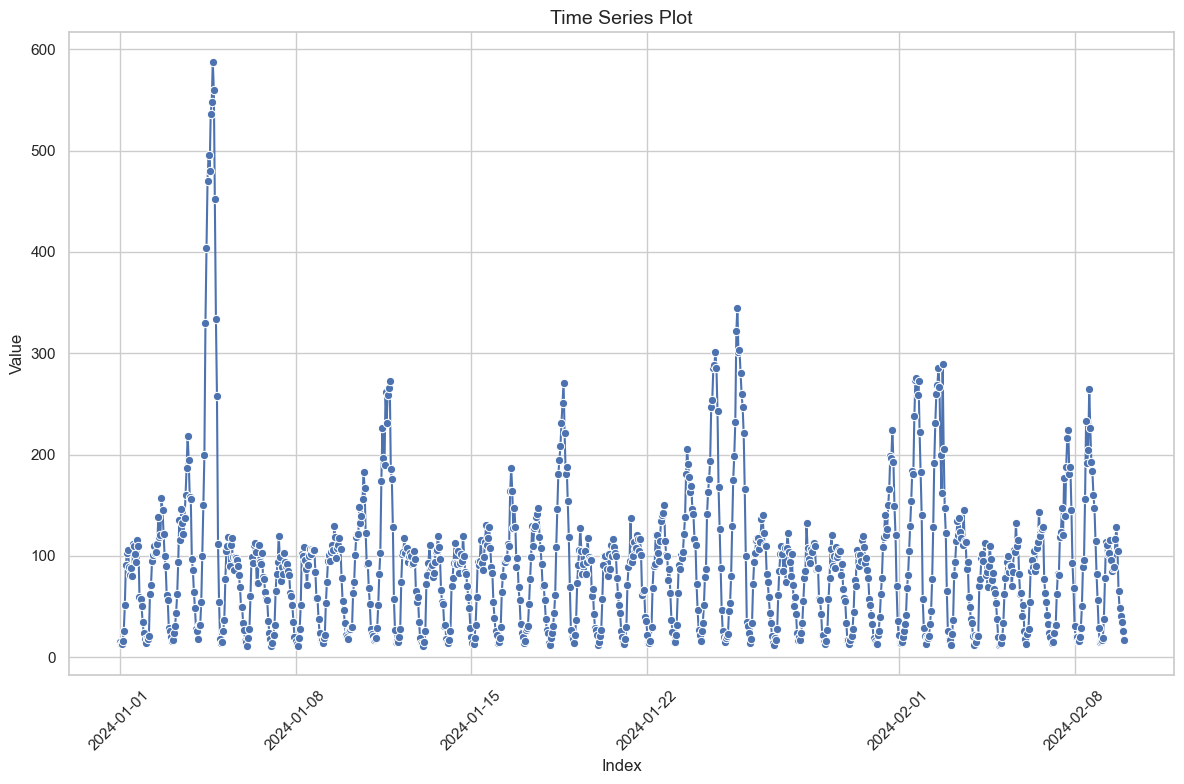

In [102]:
df_h414 = pd.DataFrame({"Index": h414.index, "Value": h414})

# Plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_h414, x="Index", y="Value", marker="o")

# Customize the plot
plt.xlabel("Index", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Time Series Plot", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

What these plots show:
ACF (Autocorrelation Function): Correlation of the series with its own lagged values.
PACF (Partial Autocorrelation Function): Correlation of the series with its lagged values, after removing the effects of earlier lags.

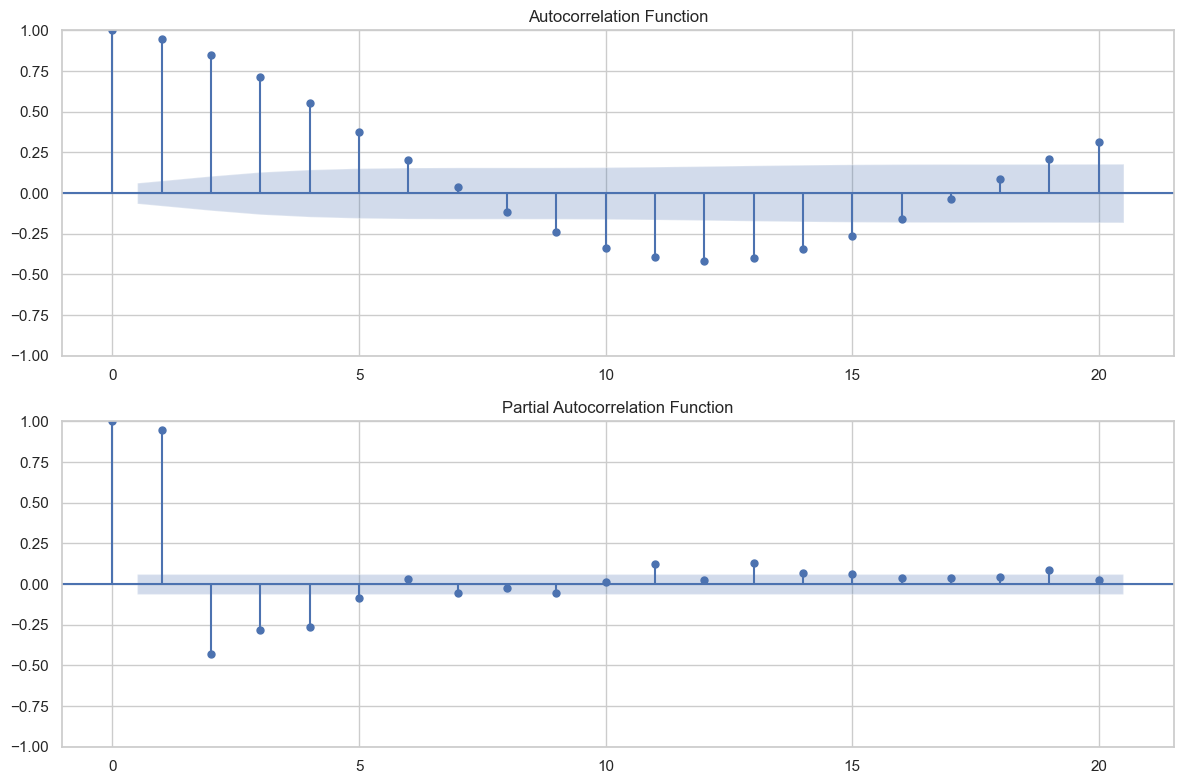

In [103]:
# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_h414["Value"], ax=axes[0], lags=20, title="Autocorrelation Function")
plot_pacf(df_h414["Value"], ax=axes[1], lags=20, title="Partial Autocorrelation Function")

plt.tight_layout()
plt.show()

Autocorrelation of H414 at lag 8: 0.7172


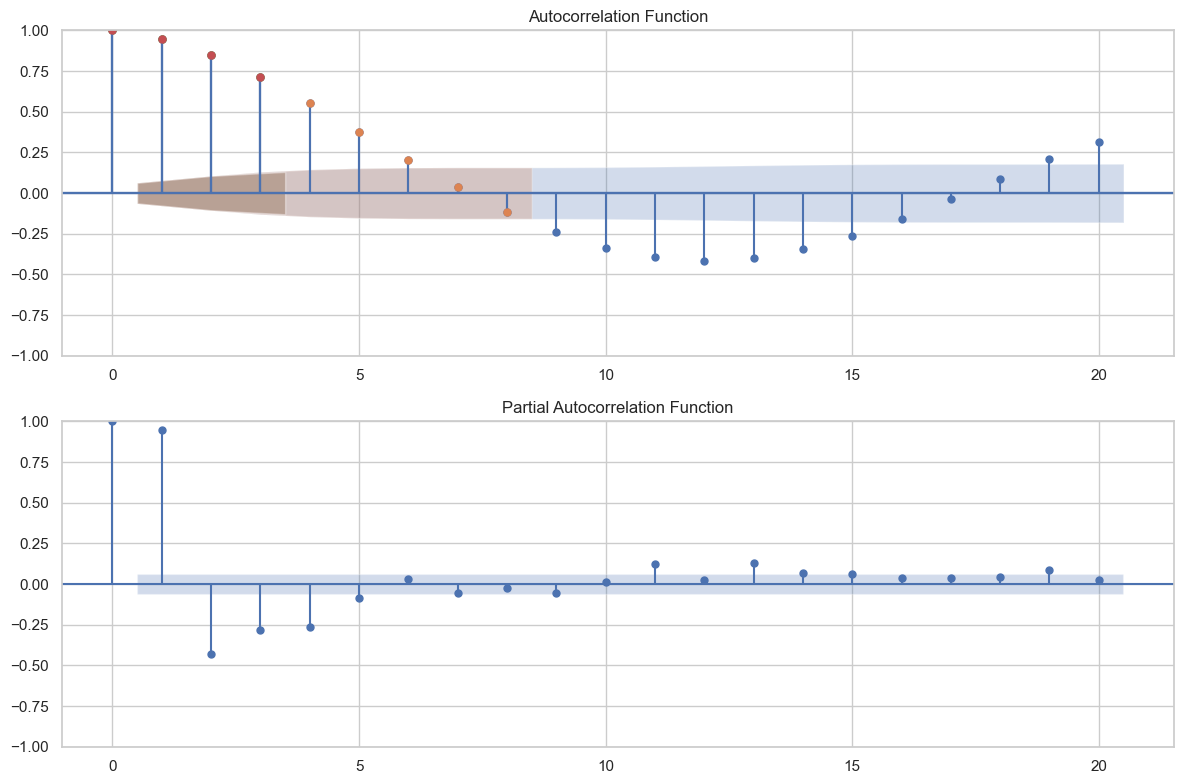

In [115]:
# Calculate the autocorrelation at lag 8
autocorr_lag_8 = df_h414["Value"].autocorr(lag=3)
print(f"Autocorrelation of H414 at lag 8: {autocorr_lag_8:.4f}")

plot_acf(df_h414["Value"], ax=axes[0], lags=3, title="Autocorrelation Function")

The STL (Seasonal-Trend Decomposition using LOESS) method is excellent for decomposing a time series into seasonal, trend, and residual components

What you’ll get:
Observed: The original time series.
Trend: Long-term movement in the data.
Seasonal: Periodic patterns (like yearly or monthly seasonality).
Residual: Remaining noise after removing trend and seasonality.

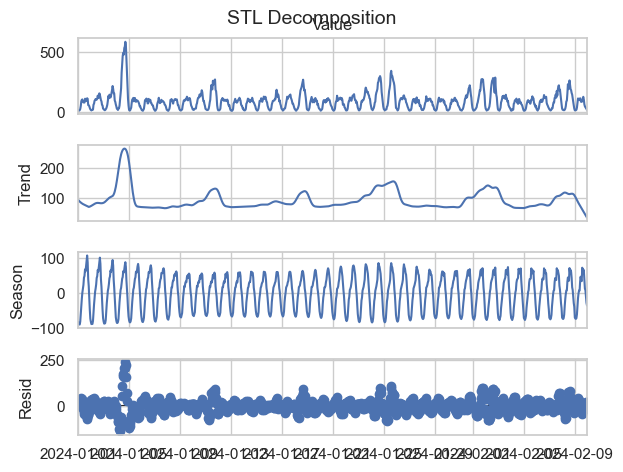

In [105]:
stl = STL(df_h414["Value"], seasonal=13)  # Adjust the seasonal period if needed
result = stl.fit()

# Plot the decomposition
result.plot()
plt.suptitle("STL Decomposition", fontsize=14)
plt.show()


The Augmented Dickey-Fuller (ADF) test checks whether a time series is stationary or not. In a stationary series, statistical properties (like mean and variance) do not change over time.

Key Outputs:
ADF Statistic: Test statistic for stationarity.
p-value: Probability of the null hypothesis (non-stationarity).
Critical Values: Thresholds for stationarity at 1%, 5%, and 10% significance levels.

In [106]:
# Perform the ADF test
result = adfuller(df_h414["Value"])

# Print results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value:.3f}")

# Interpretation
if result[1] < 0.05:
    print("\nThe series is stationary (reject the null hypothesis).")
else:
    print("\nThe series is not stationary (fail to reject the null hypothesis).")

ADF Statistic: -4.352926524148894
p-value: 0.0003592537962683956
Critical Values:
   1%: -3.437
   5%: -2.865
   10%: -2.568

The series is stationary (reject the null hypothesis).


Explanation:
Training Set (First 30 days): Used to train the model.
Validation Set (Next 6 days): Used to tune the model.
Test Set (Remaining Days): Used to evaluate the final performance.

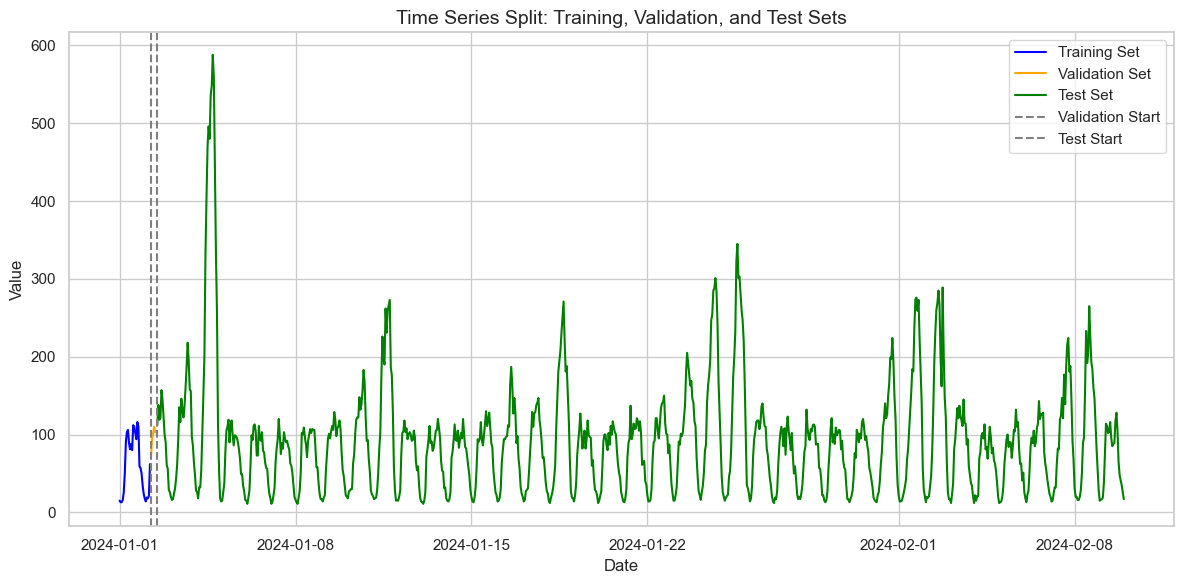

In [107]:
# Split the data
df_h414_copy = df_h414.copy()

train = df_h414_copy.iloc[:30]
validation = df_h414_copy.iloc[30:36]
test = df_h414_copy.iloc[36:]

# Plot the splits
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["Value"], label="Training Set", color="blue")
plt.plot(validation.index, validation["Value"], label="Validation Set", color="orange")
plt.plot(test.index, test["Value"], label="Test Set", color="green")

# Customize the plot
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Time Series Split: Training, Validation, and Test Sets", fontsize=14)
plt.axvline(x=validation.index[0], color="gray", linestyle="--", label="Validation Start")
plt.axvline(x=test.index[0], color="gray", linestyle="--", label="Test Start")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

To create a baseline model, we can follow a simple yet informative approach to set a benchmark. Based on the assumption that the time series might have some trend and seasonality, a Naïve Seasonal Model would be a reasonable choice. However, if there's no strong seasonality but a clear trend, a Drift Model might work better.

Here’s the plan:

Examine the Data (briefly to decide the best baseline model).
Naïve Model (use the last observed value as a forecast).
Evaluate and plot predictions.
1. Choice of Baseline Model
Since the sample data above had both a trend and periodic pattern, the Naïve Model will work, forecasting the most recent observed value for all future values.

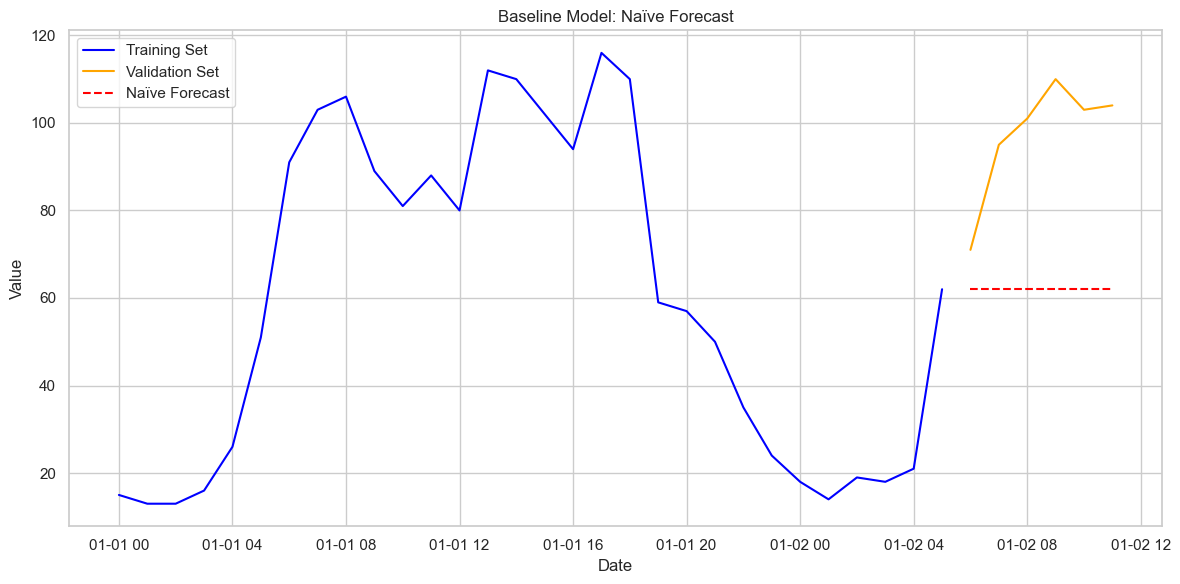

In [108]:
# Naïve Baseline Model: Forecast the last value from the training set for all future values
naive_forecast = [train["Value"].iloc[-1]] * len(validation)

# Plot the actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["Value"], label="Training Set", color="blue")
plt.plot(validation.index, validation["Value"], label="Validation Set", color="orange")
plt.plot(validation.index, naive_forecast, label="Naïve Forecast", color="red", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Baseline Model: Naïve Forecast")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

MAE, RMSE, and R² using the Naïve Baseline Model

Evaluation Metrics:

MAE (Mean Absolute Error): Average absolute error.
RMSE (Root Mean Squared Error): Penalizes larger errors more than MAE.
R² Score: How well the model explains variance. Negative R² means it performs worse than predicting the mean.

In [110]:
# Calculate evaluation metrics
mae = mean_absolute_error(validation["Value"], naive_forecast)
rmse = np.sqrt(mean_squared_error(validation["Value"], naive_forecast))
r2 = r2_score(validation["Value"], naive_forecast)

# Print the results
print("Evaluation Metrics for Naïve Baseline Model:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Evaluation Metrics for Naïve Baseline Model:
Mean Absolute Error (MAE): 35.33
Root Mean Squared Error (RMSE): 37.51
R² Score: -7.89


To select the best 𝑝 and 𝑞 values for an ARMA model based on the Akaike Information Criterion (AIC), we will perform a grid search over a range of values and choose the combination that minimizes the AIC.

Step-by-Step Plan:
Set a range for 𝑝 and 𝑞 (usually between 0 and 5 for simplicity).
Fit ARMA models for each combination of 𝑝 and 𝑞.
Calculate the AIC for each model.
Select the model with the lowest AIC.

In [120]:
def optimize_arma_model(timeseries, orders):
    results = []
    for p, q in orders:
        try:
            model = SARIMAX(timeseries, order=(p, 0, q), simple_differencing=False).fit(disp=False)
        except:
            continue
        results.append([(p, q), model.aic])
    result = pd.DataFrame(results, columns=['(p, q)', 'AIC'])
    return result.sort_values(by='AIC', ascending=True)

In [ ]:
ps = range(0, 5, 1)
qs = range(0, 10, 1)

train_x = df_h414_copy.iloc[:30*24]

orders = list(product(ps, qs))
result_df = optimize_arma_model(train['Value'], orders)
result_df.head

<bound method NDFrame.head of     (p, q)          AIC
48  (4, 8)  6255.714157
49  (4, 9)  6257.373647
37  (3, 7)  6259.002514
38  (3, 8)  6259.302108
32  (3, 2)  6265.583689
44  (4, 4)  6265.974175
47  (4, 7)  6270.641488
39  (3, 9)  6289.879828
29  (2, 9)  6303.684228
28  (2, 8)  6312.118461
27  (2, 7)  6313.668465
45  (4, 5)  6321.430299
46  (4, 6)  6322.521153
26  (2, 6)  6327.961683
18  (1, 8)  6329.586727
42  (4, 2)  6330.520839
23  (2, 3)  6330.564342
24  (2, 4)  6332.336370
33  (3, 3)  6332.419394
43  (4, 3)  6332.518835
35  (3, 5)  6332.854563
36  (3, 6)  6333.406623
16  (1, 6)  6333.726977
34  (3, 4)  6334.306351
17  (1, 7)  6334.338245
40  (4, 0)  6335.492274
41  (4, 1)  6336.327050
14  (1, 4)  6337.121883
15  (1, 5)  6338.736004
25  (2, 5)  6340.744293
22  (2, 2)  6341.029575
31  (3, 1)  6344.079946
21  (2, 1)  6345.425905
19  (1, 9)  6348.501986
30  (3, 0)  6350.756888
13  (1, 3)  6358.836946
20  (2, 0)  6386.864751
12  (1, 2)  6416.073466
11  (1, 1)  6448.777156
10  (1, 0)

In [132]:
result_df

,"(p, q)",AIC
48,"(4, 8)",6255.714157
49,"(4, 9)",6257.373647
37,"(3, 7)",6259.002514
38,"(3, 8)",6259.302108
32,"(3, 2)",6265.583689
44,"(4, 4)",6265.974175
47,"(4, 7)",6270.641488
39,"(3, 9)",6289.879828
29,"(2, 9)",6303.684228
28,"(2, 8)",6312.118461


In [116]:
# Define the range for p and q
p_range = range(0, 5, 1)
q_range = range(0, 10, 1)

train_x = df_h414_copy.iloc[:30*24]

# Perform grid search to find the best (p, q) based on AIC
best_aic = np.inf
best_order = None
aic_results = []

for p in p_range:
    for q in q_range:
        try:
            model = ARIMA(train_x["Value"], order=(p, 0, q))
            result = model.fit()
            aic = result.aic
            aic_results.append((p, q, aic))
            if aic < best_aic:
                best_aic = aic
                best_order = (p, q)
        except Exception as e:
            continue

# Print the best (p, q) and corresponding AIC
print(f"Best (p, q): {best_order} with AIC: {best_aic:.2f}")

# Sort and display all AIC results
sorted_results = sorted(aic_results, key=lambda x: x[2])
for p, q, aic in sorted_results[:5]:
    print(f"(p, q): ({p}, {q}), AIC: {aic:.2f}")


Best (p, q): (3, 6) with AIC: 6237.71
(p, q): (3, 6), AIC: 6237.71
(p, q): (3, 8), AIC: 6239.45
(p, q): (4, 7), AIC: 6239.72
(p, q): (4, 6), AIC: 6241.51
(p, q): (3, 9), AIC: 6249.05


Once we have identified the best combination of 𝑝 and 𝑞 using the AIC criterion, we can train the ARMA model on the entire dataset and examine the residuals. The residuals of a well-fitting model should ideally exhibit no significant patterns and should resemble white noise (i.e., no autocorrelation).

Here's how we can proceed:

Train the ARMA model using the best values for 𝑝 and 𝑞.
Plot the residuals to check for patterns, trends, or autocorrelation.
Perform a statistical test (e.g., ADF test or autocorrelation of residuals) to confirm the residuals are white noise.

Steps in the Code:
Train ARMA model: We train the ARMA model using the best 𝑝 and 𝑞 found in the previous step.

Residual plots:
Residual Plot: Shows if there are any obvious patterns or trends in the residuals.
ACF Plot of Residuals: Checks for autocorrelation in residuals (ideally, no significant lags should be correlated).
Ljung-Box Test: A statistical test to check if residuals exhibit autocorrelation. A p-value greater than 0.05 indicates that the residuals are white noise, suggesting the model is valid for forecasting.
Interpretation:
Residual Plot: We want to see a "random scatter" around 0 with no clear patterns.
ACF of Residuals: No significant spikes at any lag indicate that the residuals are uncorrelated.
Ljung-Box Test: If all p-values are greater than 0.05, we can conclude that the residuals are white noise.

8262.64546413259


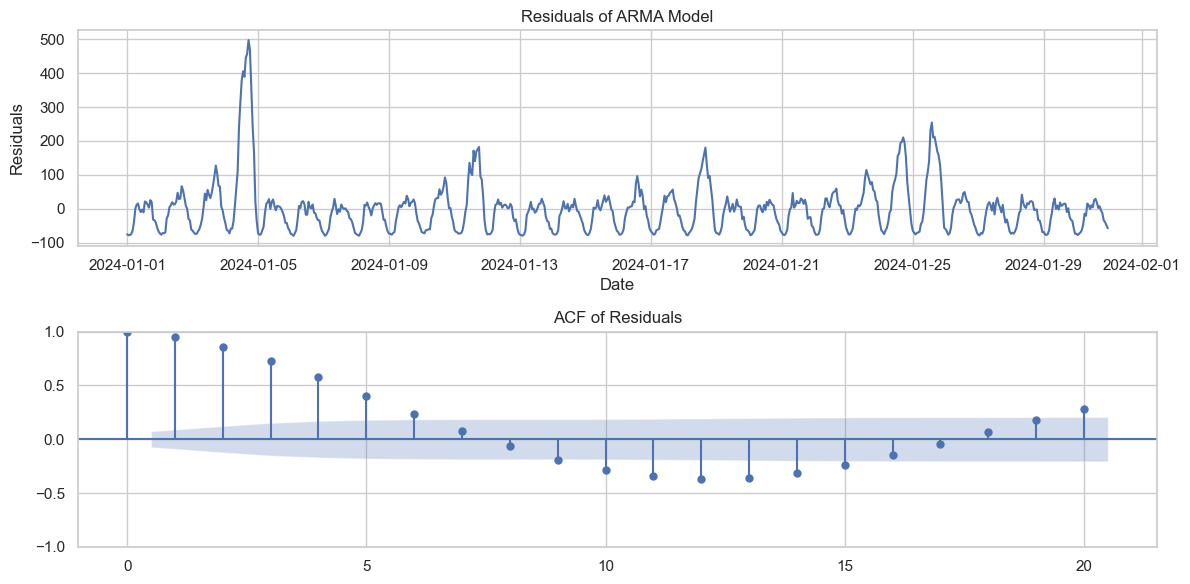

Ljung-Box Test Results (p-values):
        lb_stat      lb_pvalue
1    654.042915  2.950265e-144
2   1187.455937  1.403523e-258
3   1574.648955   0.000000e+00
4   1813.924792   0.000000e+00
5   1933.494178   0.000000e+00
6   1974.926758   0.000000e+00
7   1979.362427   0.000000e+00
8   1982.574580   0.000000e+00
9   2008.982886   0.000000e+00
10  2068.240457   0.000000e+00

Residuals show autocorrelation, the model may not be valid for forecasting.


In [112]:
# Use the best (p, q) from previous analysis
best_order = (0, 0, 0)

# Train the ARMA model
model = ARIMA(train_x["Value"], order=best_order)
result = model.fit()

aic = result.aic

print(aic)
# Residuals from the model
residuals = result.resid

# Plot the residuals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(residuals)
plt.title("Residuals of ARMA Model")
plt.xlabel("Date")
plt.ylabel("Residuals")

# Plot the ACF of residuals to check for autocorrelation

plt.subplot(2, 1, 2)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title("ACF of Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation in residuals
lb_test = acorr_ljungbox(residuals, lags=10)
print("Ljung-Box Test Results (p-values):")
print(lb_test)

# Check if residuals are white noise
if (lb_test.lb_pvalue[1] > 0.05).all():
    print("\nResiduals are white noise, model is valid for forecasting.")
else:
    print("\nResiduals show autocorrelation, the model may not be valid for forecasting.")

In [119]:
# Split the data: Training (first 30 days), Validation (next 6 days), Test (last 4 days)
train = df_h414_copy.iloc[:30*24]  # First 30 days (30*24 hours)
validation = df_h414_copy.iloc[30*24:36*24]  # Next 6 days (6*24 hours)
test = df_h414_copy.iloc[36*24:40*24]  # Last 4 days (4*24 hours)

# Baseline model: Predict the mean of the training set for the validation set
mean_value = train["Value"].mean()  # Mean of the training set

# Predict the mean value for all of the validation set
baseline_predictions = np.full_like(validation["Value"], mean_value)

# Ground truth values for the validation set
ground_truth = validation["Value"].values

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(ground_truth, baseline_predictions))
mae = mean_absolute_error(ground_truth, baseline_predictions)

print(f"Root Mean Squared Error (RMSE) of the Baseline Model: {rmse:.4f}")
print(f"Mean Absolute Error (MAE) of the Baseline Model: {mae:.4f}")



Root Mean Squared Error (RMSE) of the Baseline Model: 72.2041
Mean Absolute Error (MAE) of the Baseline Model: 56.1969


In [ ]:
df_h414_copy_2 = df_h414.copy()

train = df_h414_copy_2.iloc[:30]
validation = df_h414_copy_2.iloc[30:36]
test = df_h414_copy_2.iloc[36:40]

In [89]:
result = adfuller(train["Value"])

# Print results
print("ADF Statistic:", result[0])

ADF Statistic: -1.5690814581855088


   V1      V2      V3      V4      V5      V6      V7      V8      V9     V10  \
0  H1   605.0   586.0   586.0   559.0   511.0   443.0   422.0   395.0   382.0   
1  H2  3124.0  2990.0  2862.0  2809.0  2544.0  2201.0  1996.0  1861.0  1735.0   
2  H3  1828.0  1806.0  1897.0  1750.0  1679.0  1620.0  1463.0  1342.0  1192.0   
3  H4  6454.0  6324.0  6075.0  5949.0  5858.0  5579.0  5163.0  4790.0  4478.0   
4  H5  4263.0  4297.0  4236.0  4080.0  3883.0  3672.0  3248.0  2841.0  2513.0   

   ...  V952  V953  V954  V955  V956  V957  V958  V959  V960  V961  
0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 961 columns]


<Figure size 1000x600 with 0 Axes>

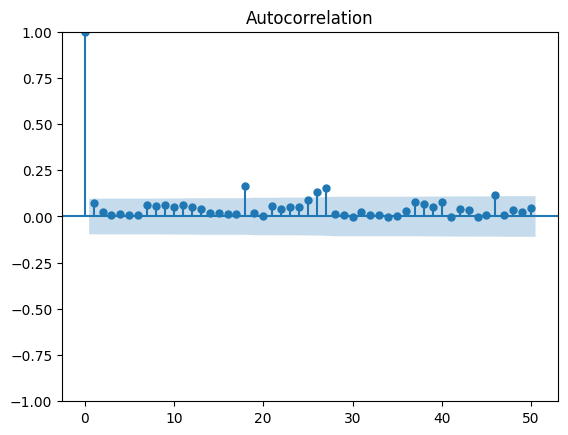

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

# Load the time series data
url = "https://raw.githubusercontent.com/Mcompetitions/M4-methods/refs/heads/master/Dataset/Train/Hourly-train.csv"
data = pd.read_csv(url)

# Check the structure of the dataset
print(data.head())

# If there is a time column, we may need to convert it into a datetime type and set it as the index
# Assuming the 'time' column exists
# data['Time'] = pd.to_datetime(data['Time']) # Uncomment if necessary
# data.set_index('Time', inplace=True) # Uncomment if necessary

# Select the column with the time series data (let's assume it's the first column)
ts = data.iloc[:, 1]  # Replace with the appropriate column name if needed

# Drop NaN values
ts_clean = ts.dropna()

# Plot the Autocorrelation Function (ACF)
plt.figure(figsize=(10,6))
plot_acf(ts_clean, lags=50)  # You can adjust the number of lags depending on your data
plt.show()


In [17]:
import pandas as pd

# Read the dataset
url = "https://raw.githubusercontent.com/Mcompetitions/M4-methods/refs/heads/master/Dataset/Train/Hourly-train.csv"
data = pd.read_csv(url)

# Filter rows for time series H414
h414_data = data[data['V1'] == 'H414']

# Calculate the number of days
num_days = len(h414_data) 

print(f"The number of days for time series H414 is: {int(num_days)}")

The number of days for time series H414 is: 1


In [9]:
import pandas as pd

# Read the dataset
url = "https://raw.githubusercontent.com/Mcompetitions/M4-methods/refs/heads/master/Dataset/Train/Hourly-train.csv"
data = pd.read_csv(url)

# Extract the H414 time series (assuming the data is in long format with values in columns)
h414_values = data[data['V1'] == 'H414'].iloc[:, 1:].values.flatten()  # Convert to a 1D array

# Calculate autocorrelation at lag 1
autocorr_lag1 = pd.Series(h414_values).autocorr(lag=1)

# Print the result with 2 decimal places
print(f"The autocorrelation at lag 1 for H414 is: {autocorr_lag1:.2f}")

The autocorrelation at lag 1 for H414 is: 0.95


In [10]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Read the dataset
url = "https://raw.githubusercontent.com/Mcompetitions/M4-methods/refs/heads/master/Dataset/Train/Hourly-train.csv"
data = pd.read_csv(url)

# Extract H414 time series as a flattened array
h414_values = data[data['V1'] == 'H414'].iloc[:, 1:].values.flatten()

# Check how many values there are in a day (assuming hourly data)
hours_per_day = 24
total_days = len(h414_values) // hours_per_day

# Split the time series
train = h414_values[:30 * hours_per_day]       # First 30 days for training
validation = h414_values[30 * hours_per_day:36 * hours_per_day]  # Next 6 days for validation
test = h414_values[36 * hours_per_day:40 * hours_per_day]  # Last 4 days for testing

# Perform the Augmented Dickey-Fuller test on the training set
adf_statistic, p_value, _, _, _, _ = adfuller(train)

# Print the ADF statistic
print(f"The ADF statistic for the training set is: {adf_statistic:.2f}")

The ADF statistic for the training set is: -3.40


In [ ]:
import pandas as pd
from sklearn.metrics import r2_score

# Read the dataset
url = "https://raw.githubusercontent.com/Mcompetitions/M4-methods/refs/heads/master/Dataset/Train/Hourly-train.csv"
data = pd.read_csv(url)

# Extract H414 time series as a flattened array
h414_values = data[data['V1'] == 'H414'].iloc[:, 1:].values.flatten()

# Check how many values there are in a day (assuming hourly data)
hours_per_day = 24

# Split the time series
train = h414_values[:30 * hours_per_day]       # First 30 days for training
validation = h414_values[30 * hours_per_day:36 * hours_per_day]  # Next 6 days for validation
test = h414_values[36 * hours_per_day:40 * hours_per_day]  # Last 4 days for testing

# Create a baseline model: replicate the last 6 days from the training set into the validation set
baseline_prediction = train[-6 * hours_per_day:]  # Last 6 days of the training set

# Calculate the R² value between the ground truth (validation) and the predicted baseline
r2 = r2_score(validation, baseline_prediction)

print(f"The R² value for the baseline model is: {r2:.2f}")

The R² value for the baseline model is: 38.82


In [93]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

# Split the data: Training (first 30 days), Validation (next 6 days), Test (last 4 days)
train = df_h414.iloc[:30*24]  # First 30 days (30*24 hours)
validation = df_h414.iloc[30*24:36*24]  # Next 6 days (6*24 hours)
test = df_h414.iloc[36*24:40*24]  # Last 4 days (4*24 hours)

# Baseline model: Replicate the last 6 days from the training set into the validation set
baseline_predictions = train["Value"].iloc[-144:].values  # Last 6 days of the training set (144 hours)

# Ground truth values for the validation set
ground_truth = validation["Value"].values

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(ground_truth, baseline_predictions)
print(f"Mean Absolute Error (MAE) of the Baseline Model: {mae:.4f}")

Mean Absolute Error (MAE) of the Baseline Model: 0.1812


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Load the data
url = "https://raw.githubusercontent.com/Mcompetitions/M4-methods/refs/heads/master/Dataset/Train/Hourly-train.csv"
data = pd.read_csv(url)

# Extract H414 time series
h414_series = data[data['V1'] == 'H414'].iloc[:, 1:].values.flatten()

# Create date range for hourly data (assuming continuous without missing values)
date_range = pd.date_range(start="2022-01-01", periods=len(h414_series), freq='H')

# Convert to DataFrame for easier manipulation
h414_df = pd.DataFrame({'timestamp': date_range, 'value': h414_series})

# Split the data: 
# First 30 days for training, next 6 days for validation, last 4 days for testing
train = h414_df[h414_df['timestamp'] < "2022-01-31"]
validation = h414_df[(h414_df['timestamp'] >= "2022-01-31") & (h414_df['timestamp'] < "2022-02-06")]
test = h414_df[h414_df['timestamp'] >= "2022-02-06"]

# Baseline model: replicate the last 6 days from training into the validation set
baseline_prediction = train['value'].iloc[-6*24:].values  # Last 6 days (6*24 hours)
validation_ground_truth = validation['value'].values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(validation_ground_truth, baseline_prediction))
print(f"RMSE for the baseline model: {rmse:.2f}")

RMSE for the baseline model: 4249.69


In [13]:
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Load the data
url = "https://raw.githubusercontent.com/Mcompetitions/M4-methods/refs/heads/master/Dataset/Train/Hourly-train.csv"
data = pd.read_csv(url)

# Extract H414 time series
h414_series = data[data['V1'] == 'H414'].iloc[:, 1:].values.flatten()

# Create date range for hourly data (assuming continuous without missing values)
date_range = pd.date_range(start="2022-01-01", periods=len(h414_series), freq='H')

# Convert to DataFrame for easier manipulation
h414_df = pd.DataFrame({'timestamp': date_range, 'value': h414_series})

# Split the data: 
train = h414_df[h414_df['timestamp'] < "2022-01-31"]['value']
validation = h414_df[(h414_df['timestamp'] >= "2022-01-31") & (h414_df['timestamp'] < "2022-02-06")]['value']
test = h414_df[h414_df['timestamp'] >= "2022-02-06"]['value']

# Function to optimize ARMA model
def optimize_arma_model(train_series, p_values, q_values):
    best_aic = np.inf
    best_order = None
    best_model = None
    
    for p, q in itertools.product(p_values, q_values):
        try:
            model = ARIMA(train_series, order=(p, 0, q)).fit()
            aic = model.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, q)
                best_model = model
        except Exception as e:
            continue
            
    return best_order, best_aic, best_model

# Define ranges for p and q
ps = range(0, 5, 1)
qs = range(0, 5, 1)

# Find the best (p, q) combination
best_order, best_aic, best_model = optimize_arma_model(train, ps, qs)
print(f"Best order: {best_order}, Best AIC: {best_aic:.2f}")

C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

Best order: (3, 6), Best AIC: 6237.71


C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC score for ARMA(4,3) model: 10029.579090405694


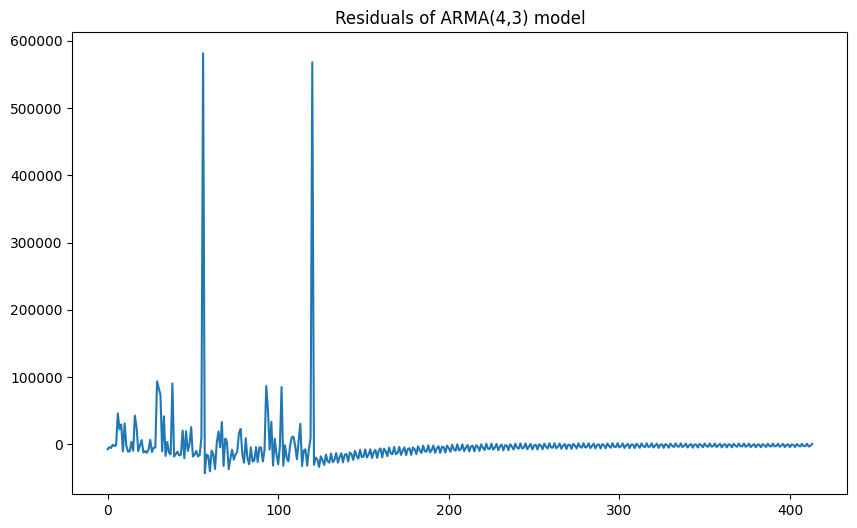

In [15]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load the dataset
url = "https://raw.githubusercontent.com/Mcompetitions/M4-methods/refs/heads/master/Dataset/Train/Hourly-train.csv"
df = pd.read_csv(url)

# Assuming the time series data is in the 'H414' column
h414_series = data[data['V1'] == 'H414'].iloc[:, 1:].values.flatten()

# Split the data into training, validation, and test sets
train_size = 30 * 24  # 30 days, hourly data
validation_size = 6 * 24  # 6 days, hourly data
test_size = 4 * 24  # 4 days, hourly data

train = ts[:train_size]
validation = ts[train_size:train_size + validation_size]
test = ts[train_size + validation_size:train_size + validation_size + test_size]

# Fit ARMA(4,3) model on the training set
model = ARIMA(train, order=(4, 0, 3))  # ARMA is ARIMA with d=0
model_fitted = model.fit()

# Get the AIC score
aic_score = model_fitted.aic
print(f"AIC score for ARMA(4,3) model: {aic_score}")

# Optionally, you can plot the residuals
residuals = model_fitted.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title("Residuals of ARMA(4,3) model")
plt.show()